In [1]:
import spacy, pandas, numpy, string
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# LOAD DATA
def load_data(path):
    
    data_raw = open(path + '_distr.csv', encoding = 'utf-8').read()
    data_list = data_raw.split('\n')
    input_table = [row.split(';') for row in data_list]
    
#    print('data load from ' + path + ' is done')
    return input_table  

In [3]:
# EXTRACT TRANSCRIPTION ID's, DOMINANT TOPIC, TOPIC DISTRIBUTION AS VECTOR 
def extract_data(input_table):
    
    work_table = []
    for i in range(1, len(input_table)-1):    
        topic_vector = []
        for j in range(12, len(input_table[i])-1):
            topic_vector.append(float(input_table[i][j].replace('"', '')))
        work_table.append([input_table[i][0], input_table[i][1], input_table[i][len(input_table[i])-1], topic_vector])   

#    print('data extraction done')
    return work_table

In [4]:
# GROUP TRANSCRIPTIONS BY DOMINANT TOPIC
def create_clusters(work_table):  
    
    # CREATE AGGREGATION LEVELS
    topics = []
    for i in range(0, len(work_table)-1):
        if work_table[i][2] not in topics:
            topics.append(work_table[i][2])

    clusters = [[dominant_topic, []] for dominant_topic in topics]
   
    # SPLIT INTO CLUSTERS
    for i in range(0, len(work_table)-1):
        for j in range (0, len(clusters)):
            if (clusters[j][0] == work_table[i][2]):
                clusters[j][1].append(numpy.asarray(work_table[i][3]))

#    print('clusters done')
    return clusters

In [5]:
# EXTRACT TERMS AND WEIGHTS PER TOPIC
# TERMS_ONLY EXAMPLE: [['danken', 'fallen', 'dienstag', 'frank', 'bitten'], ['warten', 'dürfen', 'abend', 'woche', 'tagen'], ['kennen', 'spielen', 'lernen', 'easy', 'echt']]
# TERMS_WITH_WEIGHT EXAMPLE: [{'danken': '86.285', 'fallen': '78.262', 'dienstag': '68.248', 'frank': '62.249', 'bitten': '57.422'}, {'warten': '85.251', ...]
def extract_topics(path_topics):

    # LOAD
    topics_raw = open(path_topics + '_topics.csv', encoding = 'latin-1').read()
    topics_list = topics_raw.split('\n')
    topics_table = [topic.replace('(', ',').replace(')', ',').replace(' ', '').split(',') for topic in topics_list]
    
    topics_cleaned = []
    for topic in topics_table:
        cleaned = []
        for i in range(1, len(topic)):
            if (topic[i] != ''):
                cleaned.append(topic[i])
        topics_cleaned.append(cleaned)

    # EXTRACT
    terms_only = []
    terms_with_weight = []
    for i in range(0, len(topics_cleaned)-1):
        term_weight_dict = {}
        terms = []
        for j in range (0, len(topics_cleaned[i])-1):
            if j % 2 == 0:
                terms.append(topics_cleaned[i][j])
                term_weight_dict[topics_cleaned[i][j]] = float(topics_cleaned[i][j + 1])
        terms_only.append(terms)
        terms_with_weight.append(term_weight_dict)
        
#    print('topic extraction done')
    return terms_only, terms_with_weight

In [6]:
# ELBOW METHOD USING COSINE SIMILARITY
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
def calculate_cosine (clusters):  
    
    # MEASURE COSINE SIMILARITY
    avg = []
    for c in range(0, len(clusters)):
        vectors = numpy.asarray(clusters[c][1])
        cs = cosine_similarity(vectors)
        avg.append(numpy.average(cs))
        
    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))
    
    print('cosine similarity calculated')
    return average

In [7]:
# CALCULATE SEMANTIC COHERENCE
# Source: Mimno et al. 2011
def calculate_coherence(work_table, work_topics):

    #COUNT HOW MANY TIMES EACH WORD PAIR / TOPIC OCCUR TOGETHER IN DOCUMENTS
    avg = []
    for topic in range(0, len(work_topics)-1): 
        coherence = 0
        for m in range(0, len(work_topics[0])-1):   
            co_doc_frequency = 0     
            for l in range (m + 1, len(work_topics[0])):
                term2_frequency = 0.01
                for row in range(0, len(work_table)):
                    if (work_topics[topic][l] in work_table[row][1]):
                        term2_frequency += 1
                    if (work_topics[topic][m] in work_table[row][1] and work_topics[topic][l] in work_table[row][1]):
                        co_doc_frequency += 1
            coherence += numpy.log((co_doc_frequency + 1) / term2_frequency)
        avg.append(coherence) 

    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))

    print('coherence calculated')  
    return average

In [8]:
# CALCULATE EXCLUSIVITY
def calculate_exclusivity(terms_with_weight):

    # CALCULATE TERM WEIGHT IN A TOPIC COMPARED TO TERM WEIGHT IN ALL TOPICS
    avg = []
    for topic in terms_with_weight:
        exclusivity = 0.00
        for term, weight in topic.items():
            term_weight_in_all_topics = 0.00
            for topic_for_calc in terms_with_weight:
                if topic_for_calc.get(term) != None:
                    term_weight_in_all_topics += topic_for_calc[term]
            exclusivity += weight / term_weight_in_all_topics 
        avg.append(exclusivity)  
    
    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))     

    print('exclusivity calculated')  
    return average

In [9]:
# TUNERS
folder = './IO_YO/TM_1_90/'
models = ['lda', 'nmf_fr', 'nmf_kl', 'nmf_tf']
model = models[1]
min_df = 1
max_df = 90
#alpha = 0.5

# EXECUTE
elbow_cosine_list = []
elbow_coherence_list = []
elbow_exclusivity_list = []

for i in range(3, 21):

#    path_data = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)  
#    path_topics = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)

    path = folder + model + '_min1_max90_' + str(i)  
    
    work_table = extract_data(load_data(path))
    terms_only, terms_with_weight = extract_topics(path) 
    
    # CALCULATE COSINE SIMILARITY
    average_cosine = calculate_cosine(create_clusters(work_table))    
    elbow_cosine_list.append(average_cosine)

    # CALCULATE COHERENCE  
    average_coherence = calculate_coherence(work_table, terms_only)
    elbow_coherence_list.append(average_coherence)
    
    # CALCULATE EXCLUSIVITY
    average_exclusivity = calculate_exclusivity(terms_with_weight)
    elbow_exclusivity_list.append(average_exclusivity)    

    print('process for ' + path + ' is done')    

cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_3 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_4 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_5 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_6 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_7 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_8 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_9 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1

Text(0.5, 1.0, 'cosine sim.: nmf_fr, min_df: 1, max_df: 90')

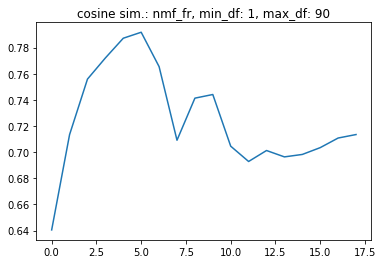

In [10]:
# VISUALIZE COSINE SIMILARITY
plt.plot(elbow_cosine_list)
plt.title('cosine sim.: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

Text(0.5, 1.0, 'coherence: nmf_fr, min_df: 1, max_df: 90')

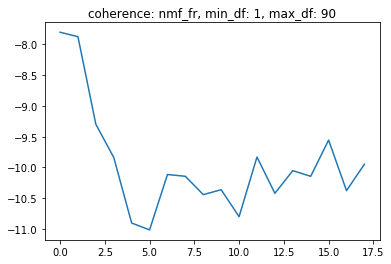

In [11]:
# VISUALIZE COHERENCE
plt.plot(elbow_coherence_list)
plt.title('coherence: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

Text(0.5, 1.0, 'exclusivity: nmf_fr, min_df: 1, max_df: 90')

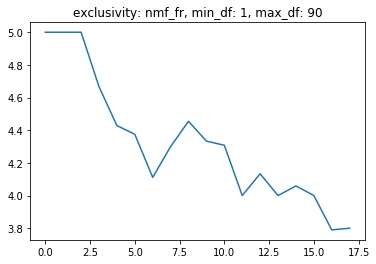

In [12]:
# VISUALIZE EXCLUSIVITY
plt.plot(elbow_exclusivity_list)
plt.title('exclusivity: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

In [13]:
# TUNERS
folder = './IO_YO/TM_1_90/'
models = ['lda', 'nmf_fr', 'nmf_kl', 'nmf_tf']
model = models[2]
min_df = 1
max_df = 90
#alpha = 0.5

# EXECUTE
elbow_cosine_list = []
elbow_coherence_list = []
elbow_exclusivity_list = []

for i in range(3, 21):

#    path_data = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)  
#    path_topics = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)

    path = folder + model + '_min1_max90_' + str(i)  
    
    work_table = extract_data(load_data(path))
    terms_only, terms_with_weight = extract_topics(path) 
    
    # CALCULATE COSINE SIMILARITY
    average_cosine = calculate_cosine(create_clusters(work_table))    
    elbow_cosine_list.append(average_cosine)

    # CALCULATE COHERENCE  
    average_coherence = calculate_coherence(work_table, terms_only)
    elbow_coherence_list.append(average_coherence)
    
    # CALCULATE EXCLUSIVITY
    average_exclusivity = calculate_exclusivity(terms_with_weight)
    elbow_exclusivity_list.append(average_exclusivity)    

    print('process for ' + path + ' is done')  

cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_3 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_4 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_5 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_6 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_7 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_8 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_kl_min1_max90_9 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1

Text(0.5, 1.0, 'cosine sim.: nmf_kl, min_df: 1, max_df: 90')

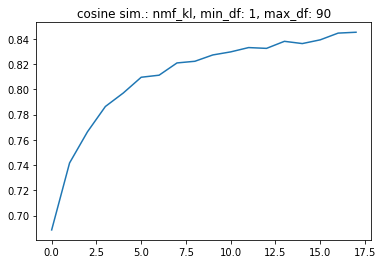

In [14]:
# VISUALIZE COSINE SIMILARITY
plt.plot(elbow_cosine_list)
plt.title('cosine sim.: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df)) 

Text(0.5, 1.0, 'coherence: nmf_kl, min_df: 1, max_df: 90')

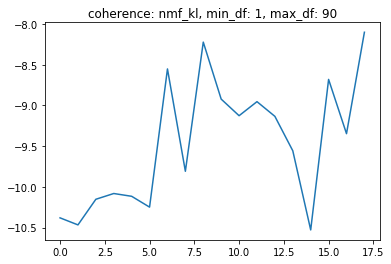

In [15]:
# VISUALIZE COHERENCE
plt.plot(elbow_coherence_list)
plt.title('coherence: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

Text(0.5, 1.0, 'exclusivity: nmf_kl, min_df: 1, max_df: 90')

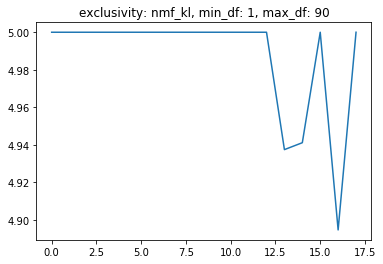

In [16]:
# VISUALIZE EXCLUSIVITY
plt.plot(elbow_exclusivity_list)
plt.title('exclusivity: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

In [17]:
# TUNERS
folder = './IO_YO/TM_1_90/'
models = ['lda', 'nmf_fr', 'nmf_kl', 'nmf_tf']
model = models[1]
min_df = 1
max_df = 90
#alpha = 0.5

# EXECUTE
elbow_cosine_list = []
elbow_coherence_list = []
elbow_exclusivity_list = []

for i in range(3, 21):

#    path_data = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)  
#    path_topics = folder + model + '_min2_max85_alfa' + str(alpha) + '_' + str(i)

    path = folder + model + '_min1_max90_' + str(i)  
    
    work_table = extract_data(load_data(path))
    terms_only, terms_with_weight = extract_topics(path) 
    
    # CALCULATE COSINE SIMILARITY
    average_cosine = calculate_cosine(create_clusters(work_table))    
    elbow_cosine_list.append(average_cosine)

    # CALCULATE COHERENCE  
    average_coherence = calculate_coherence(work_table, terms_only)
    elbow_coherence_list.append(average_coherence)
    
    # CALCULATE EXCLUSIVITY
    average_exclusivity = calculate_exclusivity(terms_with_weight)
    elbow_exclusivity_list.append(average_exclusivity)    

    print('process for ' + path + ' is done')

cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_3 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_4 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_5 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_6 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_7 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_8 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1_90/nmf_fr_min1_max90_9 is done
cosine similarity calculated
coherence calculated
exclusivity calculated
process for ./IO_YO/TM_1

Text(0.5, 1.0, 'cosine sim.: nmf_fr, min_df: 1, max_df: 90')

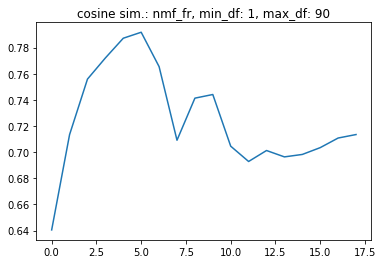

In [18]:
# VISUALIZE COSINE SIMILARITY
plt.plot(elbow_cosine_list)
plt.title('cosine sim.: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df)) 

Text(0.5, 1.0, 'coherence: nmf_fr, min_df: 1, max_df: 90')

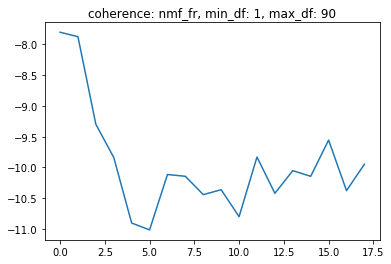

In [19]:
# VISUALIZE COHERENCE
plt.plot(elbow_coherence_list)
plt.title('coherence: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))

Text(0.5, 1.0, 'exclusivity: nmf_fr, min_df: 1, max_df: 90')

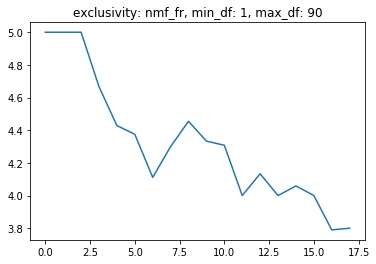

In [20]:
# VISUALIZE EXCLUSIVITY
plt.plot(elbow_exclusivity_list)
plt.title('exclusivity: ' + model + ', min_df: ' + str(min_df) + ', max_df: ' + str(max_df))